# Berkely Intel dataset data pre-processing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Reading raw csv file while naming and typing columns
According to the documentation found on the [dataset's website](http://db.csail.mit.edu/labdata/labdata.html).

In [2]:
raw_colnames = ['date', 'time', 'epoch', 'mote_id', 'temperature', 'humidity', 'light', 'voltage']
dtypes = {
    'epoch': 'Int64',
    'mote_id': 'Int64',
    'temperature': float,
    'humidity': float,
    'light': float,
    'voltage': float
}
raw_data = pd.read_csv('../data/Sensors_Intel/data.txt',
                       sep=' ',
                       header=None,
                       names=raw_colnames,
                       dtype=dtypes,
                       parse_dates={'datetime': ['date', 'time']},
                       index_col='datetime'
                       )
raw_data

,epoch,mote_id,temperature,humidity,light,voltage
datetime,,,,,,
2004-03-31 03:38:15.757551,2,1,122.1530,-3.91901,11.04,2.03397
2004-02-28 00:59:16.027850,3,1,19.9884,37.09330,45.08,2.69964
2004-02-28 01:03:16.333930,11,1,19.3024,38.46290,45.08,2.68742
2004-02-28 01:06:16.013453,17,1,19.1652,38.80390,45.08,2.68742
2004-02-28 01:06:46.778088,18,1,19.1750,38.83790,45.08,2.69964
...,...,...,...,...,...,...
2004-04-02 01:14:54.164318,61274,<NA>,NaN,NaN,NaN,NaN
2004-04-02 01:17:53.670524,61275,<NA>,NaN,NaN,NaN,NaN
2004-04-02 01:20:52.807972,61276,<NA>,NaN,NaN,NaN,NaN


### Data Selection
The authors of [the Sensor Faults paper](http://bourbon.usc.edu/leana/papers/SharmaGG10.pdf) report using temperature readings between February 28th and April 5th, 2004.

In [3]:
data = raw_data[['epoch', 'mote_id', 'temperature', 'voltage']]
data.head()

,epoch,mote_id,temperature,voltage
datetime,,,,
2004-03-31 03:38:15.757551,2,1,122.1530,2.03397
2004-02-28 00:59:16.027850,3,1,19.9884,2.69964
2004-02-28 01:03:16.333930,11,1,19.3024,2.68742
2004-02-28 01:06:16.013453,17,1,19.1652,2.68742
2004-02-28 01:06:46.778088,18,1,19.1750,2.69964


The dataset contains data from multiple sensors. We select the one produced by mote #2.

In [4]:
selected_mote_id = 2
signal = data[data['mote_id'] == selected_mote_id] \
            .sort_values('datetime')[['temperature']]

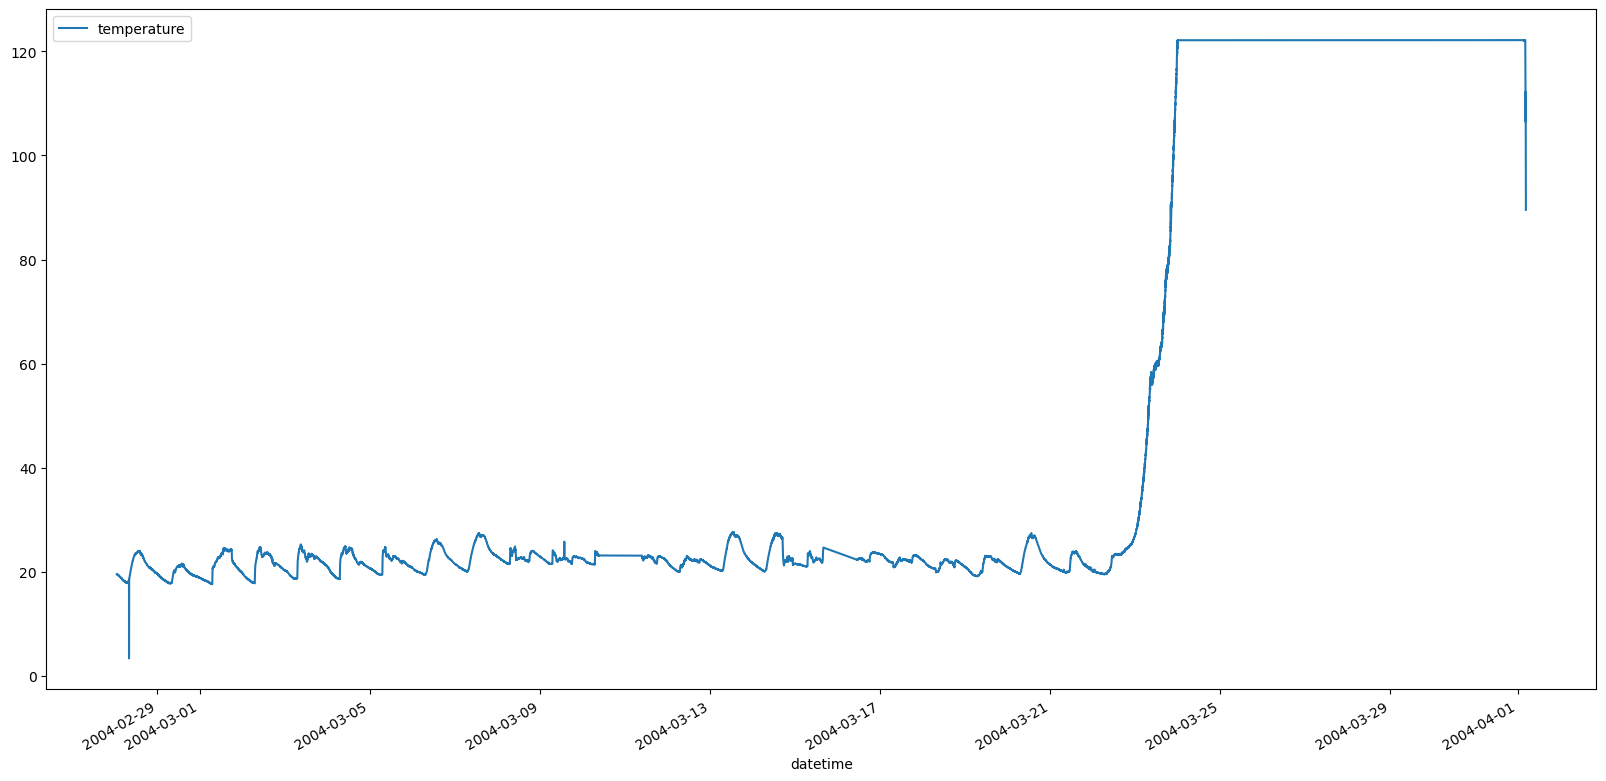

In [5]:
_ = signal.plot(figsize=(20,10))

## Data Preparation
Gfpop requires no missing data points.
Resample the data points with one every 30 minutes and complete missing data with constant interpolation.

1591


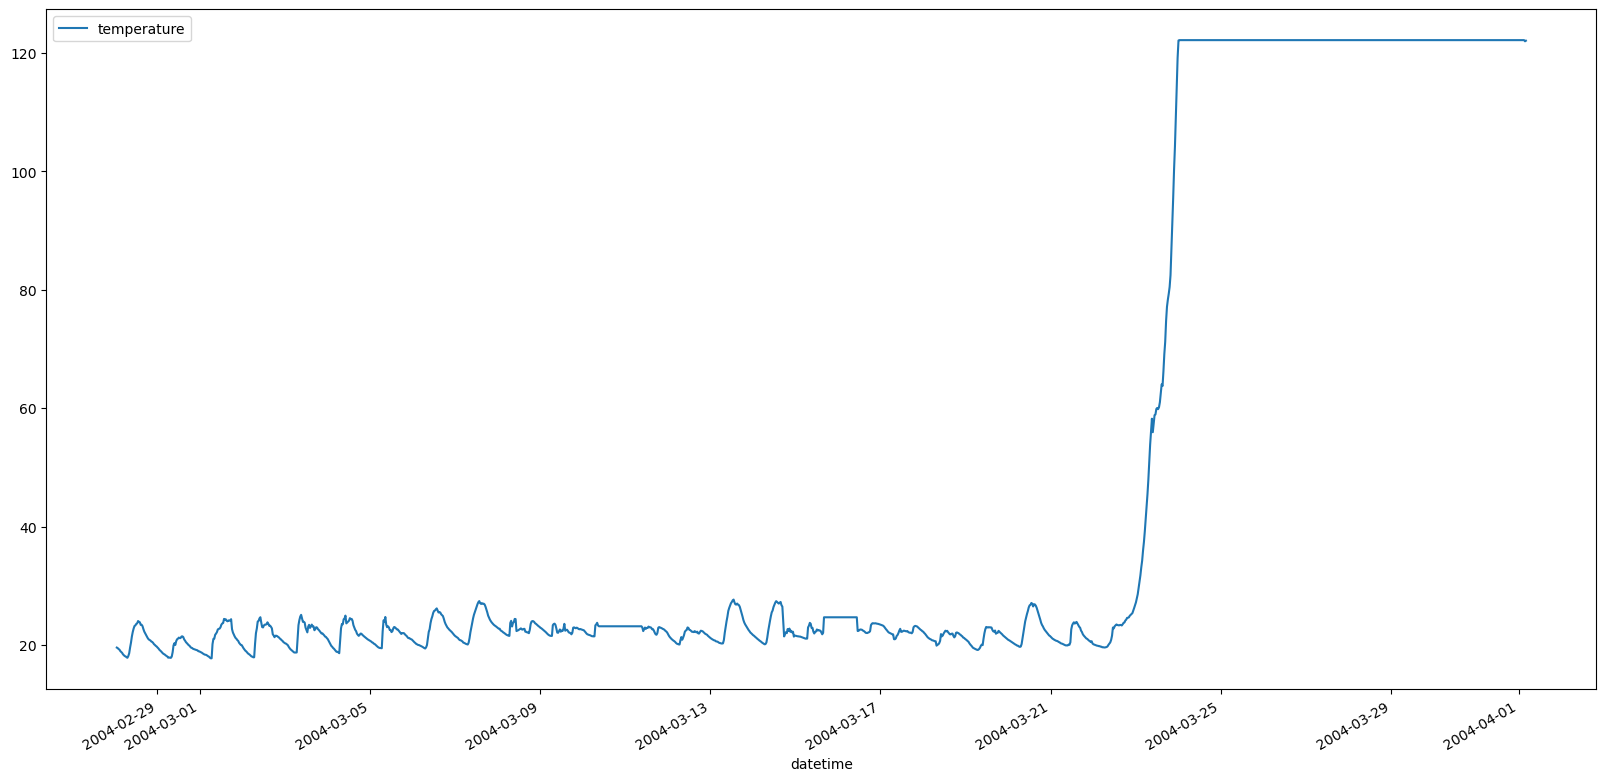

In [7]:
resampled_signal = signal.resample('30min', origin='start').ffill()
print(len(resampled_signal))
_ = resampled_signal.plot(figsize=(20, 10))

## Fault insertion
We insert fault like it is suggested by the paper. Three types of faults are given:
- SHORT
- NOISE
- CONSTANT

#### SHORT fault
Pick a sample $i$ and replace the reported value $v_i$ wiht $\hat{v_i} = v_i + f \times v_i$
$f$ is the intensity and chosen between $f=\{1.5, 2.5, 5, 10\}$

In [8]:
def add_short_faults(signal: pd.DataFrame, intensity: float, number: int, seed: int):
    signal = signal.copy()
    np.random.seed(seed)
    indices = np.random.randint(len(signal), size=number)
    signal.iloc[indices] *= intensity
    signal['SHORT'] = signal.get('SHORT', np.zeros_like(signal['temperature'], dtype=bool))
    signal.iloc[indices,-1] = True
    signal.loc["2004-02-28 08:03:40.776717", "SHORT"] = True # Annotate the SHORT fault in the dataset
    return signal

#### NOISE fault
Pick a set of successive samples and add a random value drawn from a normal distribution $N(0,\sigma^2)$ to each sample.
The intensity is varied by augmenting the standard deviation of the signal by a factor of $0.5, 1.5, 3$

In [9]:
def add_noise_fault(signal: pd.DataFrame, intensity: float, n_samples: int, seed: int):
    # Copy the dataframe and add a column for the NOISE ground truth
    signal = signal.copy()
    signal['NOISE'] = signal.get('NOISE', np.zeros_like(signal['temperature'], dtype=bool))
    columns = signal.columns.tolist()

    # Choose a start location for the section where noise will be added
    np.random.seed(seed)
    start_index = np.random.randint(len(signal) - n_samples)
    sample_indices = pd.RangeIndex(start_index, start_index + n_samples)
    sample_std = signal.iloc[sample_indices]['temperature'].std()

    # Add noise
    added_noise = np.random.normal(scale=sample_std * intensity, size=n_samples)
    signal.iloc[sample_indices, columns.index('temperature')] += added_noise
    signal.iloc[sample_indices, columns.index('NOISE')] = True
    return signal

#### CONSTANT fault
Label the fault that is already in the data

In [10]:
def label_constant_fault(signal: pd.DataFrame):
    signal = signal.copy()
    signal['CONSTANT'] = signal['temperature'] > 120
    return signal

label_constant_fault(signal)

,temperature,CONSTANT
datetime,,
2004-02-28 01:08:16.776717,19.5670,False
2004-02-28 01:10:16.105455,19.5376,False
2004-02-28 01:26:46.606579,19.4788,False
2004-02-28 01:28:16.345812,19.4494,False
2004-02-28 01:33:46.144671,19.4984,False
...,...,...
2004-04-01 04:13:48.366104,122.1530,True
2004-04-01 04:14:34.563300,120.8600,True
2004-04-01 04:26:18.948355,106.5130,False


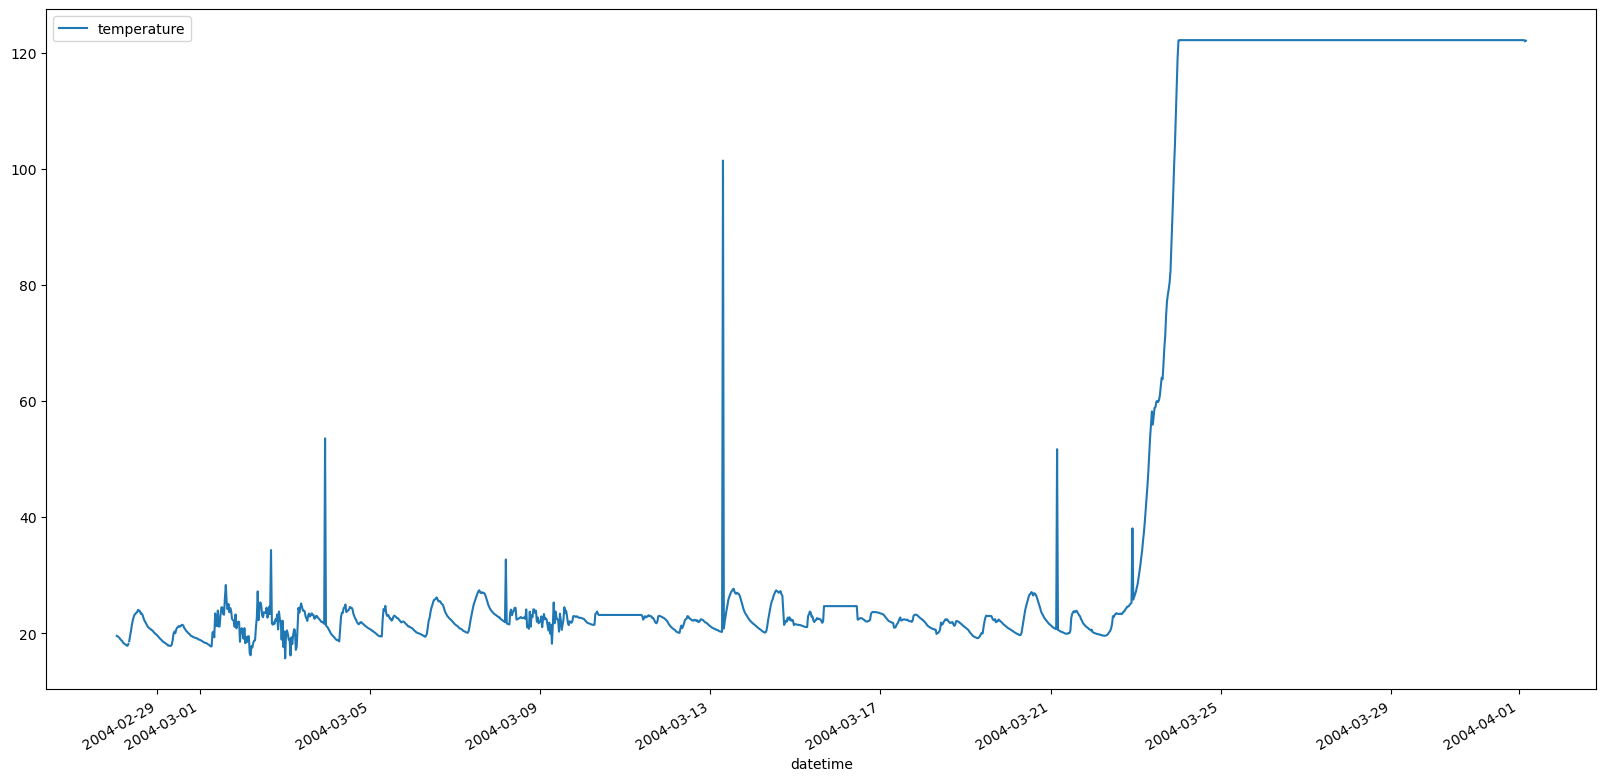

In [29]:
signal_with_faults = resampled_signal.pipe(add_short_faults, intensity=1.5, number=3, seed=4) \
                                    .pipe(add_short_faults,  intensity=2.5, number=2, seed=1) \
                                    .pipe(add_short_faults,  intensity=5, number=1, seed=0) \
                                    .pipe(add_noise_fault, intensity=0.5, n_samples=100, seed=50) \
                                    .pipe(add_noise_fault, intensity=1.5, n_samples=50, seed=55) \
                                    .pipe(label_constant_fault)


signal_with_faults.plot(figsize=(20,10))
# plt.vlines(signal_with_faults[signal_with_faults['SHORT'] == True].index, -40, 120, color='red', linestyles='dashed', label='SHORT')
# plt.vlines(signal_with_faults[signal_with_faults['NOISE'] == True].index, 0, 40, color='orange', label='NOISE', alpha=0.9)
plt.legend()
plt.show()

### Save for processing by the R program

In [30]:
signal_to_save = signal_with_faults.dropna().reset_index()
signal_to_save.index.name = 'timesteps'
signal_to_save

,datetime,temperature,SHORT,NOISE,CONSTANT
timesteps,,,,,
0,2004-02-28 01:08:16.776717,19.5670,False,False,False
1,2004-02-28 01:38:16.776717,19.4788,False,False,False
2,2004-02-28 02:08:16.776717,19.3220,False,False,False
3,2004-02-28 02:38:16.776717,19.2142,False,False,False
4,2004-02-28 03:08:16.776717,18.9692,False,False,False
...,...,...,...,...,...
1586,2004-04-01 02:08:16.776717,122.1530,False,False,True
1587,2004-04-01 02:38:16.776717,122.1530,False,False,True
1588,2004-04-01 03:08:16.776717,122.1530,False,False,True


In [31]:
signal_to_save.to_csv('../data/Sensors_Intel/signal_with_faults.csv', header=True, index=True)